Analyze the raw amplitudes of measured signal and how it behaves with increasing distance to the electronics.

In [1]:
import os
import re
import datetime

import numpy as np
from matplotlib import pyplot as plt

import preprocessing as pp
from verify_dataset_hash import verify_json_metadata, get_repo_sha1_and_diff

data_directory: directory containing measured data (train and test datasets)

debug: Set True if you want to see the header detection result during the pre processing

use_new_data: Set True if data needs to be loaded from a txt file for the first time (saves time otherwise)

In [2]:
data_directory = os.path.join("..", "DownloadedData", "AntennaSpectra", "Rev1Distance")

debug = False
use_new_data = False
num_test_data_sets = 5

offset_header_rev1 = -200
offset_header_rev2 = 200
if "rev1" in data_directory.lower():
    offset_header = offset_header_rev1
elif "rev2" in data_directory.lower():
    offset_header = offset_header_rev2
else:
    raise NotImplementedError("Specify which offset should be used!")

In [3]:
debug = False  # Set this to True if you want to see the header detection result during the pre processing

data_directory = os.path.join("..", "DownloadedData", "Rev1Distance")

# Technical details of your experimental setup
technical_details = {
    "header_length": 1,  # Number of symbols used to identify the header
    "clock_freq": int(100e6),  # Clock frequency (Hz) of the sender electronics
    "sample_freq": int(1e10),  # Sample frequency (Hz) used by oscilloscope
    "signal_length": 2_000_002,  # Total number of data points of one measurement
    "steps_to_left": 3,  # start for the cut position in symbols to the left from the header position
    "steps_to_right": 6,  # end for the cut position in symbols to the right from the header position
    "do_normalize_data": False,  # Use if data should be normalized to have zero mean and std 1
}

offset_header_rev1 = -200
offset_header_rev2 = 200
if "rev1" in data_directory.lower():
    offset_header = offset_header_rev1
elif "rev2" in data_directory.lower():
    offset_header = offset_header_rev2
else:
    raise NotImplementedError("Specify which offset should be used!")

results_std = {}
error_bars_for_std = {}
std_all_measurements = {}
consider_num_measurements = 5

for measdir_name in os.listdir(data_directory):
    measdir = os.path.join(data_directory, measdir_name)

    if os.path.isdir(measdir):
        all_std_deviations = []
        for i in range(0, consider_num_measurements):
            training_data, _, _ = pp.load_data_synchronized(
                folder_path=measdir,
                file_path=os.path.join(measdir, f"train_{i}_data.txt"),
                file_path_synch=os.path.join(measdir, f"train_{i}_synch_debug_signal.txt"),
                clock_freq=technical_details["clock_freq"],
                sample_freq=technical_details["sample_freq"],
                signal_length=technical_details["signal_length"],
                debug=debug,
                offset_header=offset_header)
            all_std_deviations.append(np.std(training_data))
        std_all_measurements[os.path.abspath(measdir)] = all_std_deviations
        results_std[os.path.abspath(measdir)] = np.mean(all_std_deviations)
        error_bars_for_std[os.path.abspath(measdir)] = np.std(all_std_deviations)
    else:
        print(f"Warning. Skipping {measdir}.")

Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/1cm
Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/1cm
Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/1cm
Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/1cm
Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/1cm
Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm
Successfully loaded data from folder /home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Dista

In [4]:
print(results_std, error_bars_for_std)

{'/home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/1cm': 0.001055404802226168, '/home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/0cm': 0.0032563136792451972, '/home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/8cm': 0.0008739449499602482, '/home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/2cm': 0.0008523651125337298, '/home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/3cm': 0.0008310484851451232, '/home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/9cm': 0.0005526771443181164, '/home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/11cm': 0.0005775093082205707, '/home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/7cm': 0.0007254472300740645, '/home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/6cm': 0.0006687222972149204, '/home/labor/git/GITHUB_EmissionSecurityQKD/DownloadedData/Rev1Distance/10cm': 0.000603955

<ErrorbarContainer object of 3 artists>

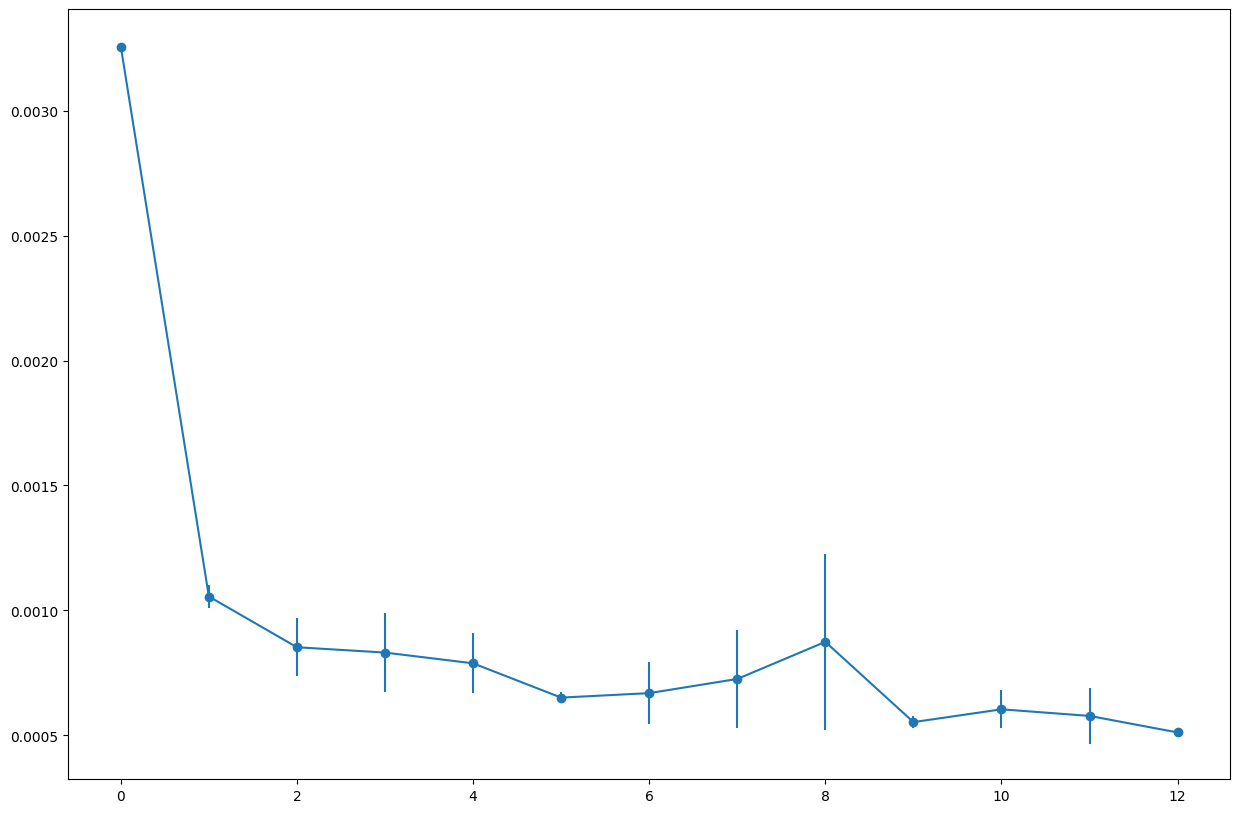

In [5]:
std_data_to_plot = {}
err_bars_to_plot = {}
std_all_measurements_to_plot = {}

# rename the keys so they can be used for plotting (on x axis)
for k in sorted(results_std.keys(), key=lambda kk: int(re.findall("(\d+)cm", kk)[0])):
    new_key = int(re.findall("(\d+)cm", k)[0])
    std_data_to_plot[new_key] = results_std[k]
    err_bars_to_plot[new_key] = error_bars_for_std[k]
    std_all_measurements_to_plot[new_key] = std_all_measurements[k]

assert (err_bars_to_plot.keys() == std_data_to_plot.keys())

plt.errorbar(std_data_to_plot.keys(), std_data_to_plot.values(), fmt='-o', label="probe signal",
             yerr=err_bars_to_plot.values()
             )

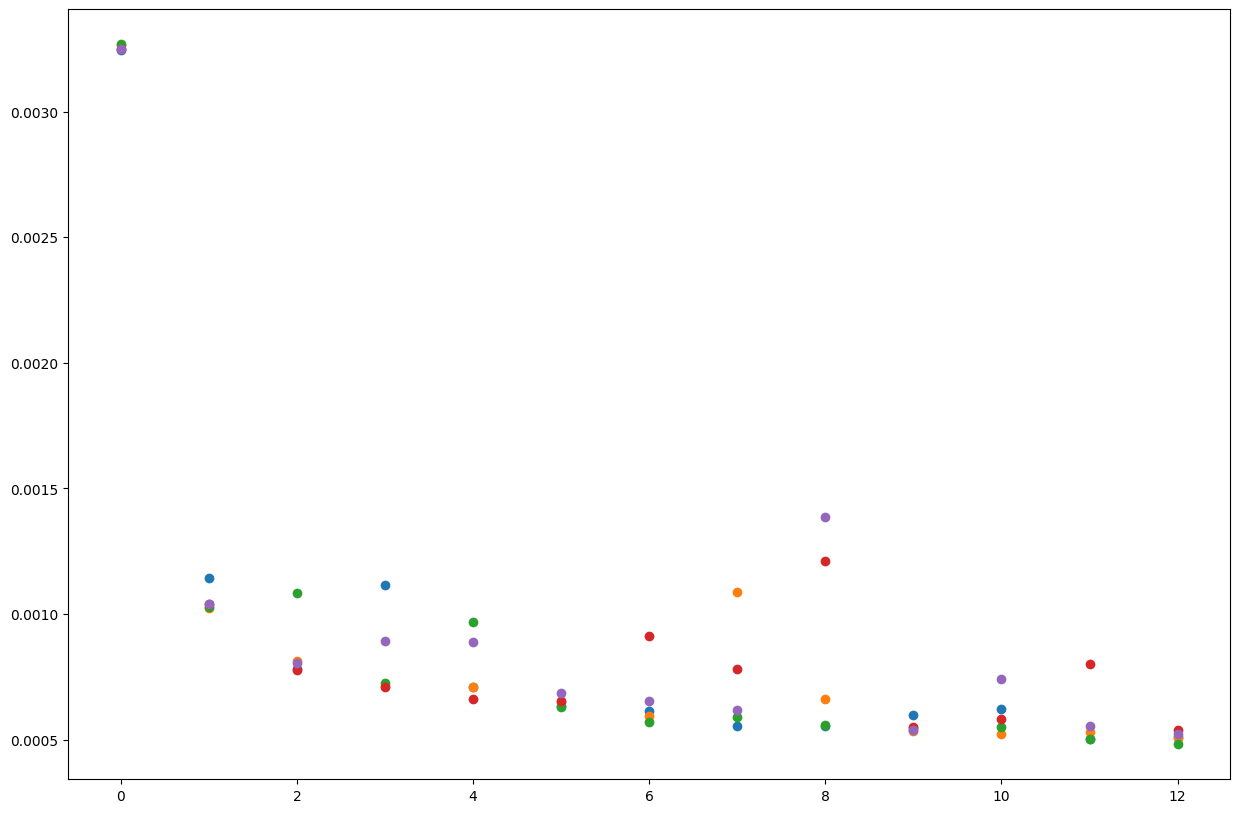

In [6]:
plt.plot(std_data_to_plot.keys(), std_all_measurements_to_plot.values(), 'o', label="probe signal", )

In [7]:
std_all_measurements_to_plot

{0: [0.003245421390574889,
  0.0032669186592563164,
  0.00326817551947777,
  0.0032508639295347765,
  0.003250188897382232],
 1: [0.0011426596694122245,
  0.0010233088910511598,
  0.0010297895323756866,
  0.0010394170534642846,
  0.001041848864827484],
 2: [0.000780818734264639,
  0.000813181451666634,
  0.0010834434213921583,
  0.0007788271911988386,
  0.0008055547641463793],
 3: [0.0011160767611036791,
  0.0007120943071708928,
  0.0007235330210126231,
  0.0007090374249396021,
  0.0008945009114988194],
 4: [0.000709592621800816,
  0.0007095226341448046,
  0.0009692366072637455,
  0.0006614170594438108,
  0.0008905416381168192],
 5: [0.0006334480117512643,
  0.000651063722962189,
  0.0006289896506914885,
  0.0006531505463774515,
  0.0006873115228582201],
 6: [0.0006143166076452793,
  0.0005932401289888742,
  0.0005702853787661676,
  0.0009122496102128245,
  0.0006535197604614565],
 7: [0.0005522399444920788,
  0.0010867147452905312,
  0.0005906225299824255,
  0.000780715510441034,
  0.

In [8]:
git_sha1, git_diff = get_repo_sha1_and_diff(search_parent_directories=True)
result_file_path = os.path.join(data_directory, f"data_raw_std_{datetime.datetime.now().strftime('%Y%m%d-%H%M')}.json")
try:
    measurement_metadata = verify_json_metadata(data_directory, verbose=False)
except:
    measurement_metadata = "FAILURE_TO_GET_METADATA"

pp.write_result_dict({
    'measurement_metadata': measurement_metadata,
    'std_probe_signal': results_std,
    'std_of_stds_across_measurements': error_bars_for_std,
    'num_measurements_considered': consider_num_measurements,
},
    target_file_path=result_file_path, override=True, )

print(" ------------ Done ---------------")

created a json file of the test accuracies at ../DownloadedData/Rev1Distance/data_raw_std_20230522-1445.json
 ------------ Done ---------------
